# CNN from scratch

This notebook builds a basic **Encoder-Decoder** variant of the Transformer architecture from scratch (Multi-Head Attention, Scaled Dot-Product Attention and Causal Masking included) in TensorFlow.

It serves to understand how each part of the Transformer works and how they all fit together.

The Transformer is then tested on a simple seq2seq task : **translating sentences from English to French**.

[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-21.png" width="300">](https://arxiv.org/abs/1706.03762)

**Steps :**
1. [Preparing the data](#Preparing-the-data)
2. [Building the Transformer](#Building-the-Transformer)
3. [Training the Transformer](#Training-the-Transformer)
4. [Testing the Transformer](#Testing-the-Transformer)
    
*[Credits and stuff](#Credits-and-stuff)*

In [1]:
import os
from IPython.display import clear_output
import shutil
import pathlib
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import re
import numpy as np

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "AVAILABLE" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.9.0

GPU is AVAILABLE


# Preparing the data

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Reading the data</b></p>
</div>

In [3]:
# get the files paths
input_dir_path = "/kaggle/input"
working_dir_path = "/kaggle/working"
input_dir_path = input_dir_path if os.path.exists(input_dir_path) else ".{}".format(input_dir_path)
working_dir_path = working_dir_path if os.path.exists(working_dir_path) else ".{}".format(working_dir_path)

train_file_path = os.path.join(input_dir_path, "dogs-vs-cats-redux-kernels-edition", "train.zip")
test_file_path = os.path.join(input_dir_path, "dogs-vs-cats-redux-kernels-edition", "test.zip")

In [4]:
# unzip the files
!unzip -o $train_file_path -d $working_dir_path
!unzip -o $test_file_path -d $working_dir_path

clear_output()

# create raw/train and raw/test directories and move the files there
raw_dir_path = os.path.join(working_dir_path, "raw")
train_dir_path = os.path.join(raw_dir_path, "train")
test_dir_path = os.path.join(raw_dir_path, "test")

os.makedirs(train_dir_path, exist_ok=True)
os.makedirs(test_dir_path, exist_ok=True)

!mv $working_dir_path/train $raw_dir_path
!mv $working_dir_path/test $raw_dir_path

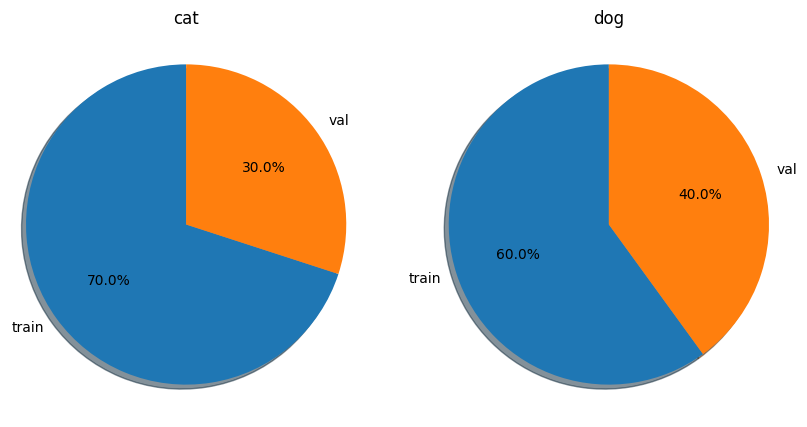

cat train count: 8750
cat val count: 3750
dog train count: 7500
dog val count: 5000


In [5]:
# count the number of jpg files in the train directory
train_dir_path = os.path.join(raw_dir_path, "train")
jpg_files = [f for f in os.listdir(train_dir_path) if f.endswith(".jpg")]

cat_jpg_files = [f for f in jpg_files if f.startswith("cat")]
dog_jpg_files = [f for f in jpg_files if f.startswith("dog")]

cat_train_size = int(len(cat_jpg_files) * 0.7)
cat_val_size = int(len(cat_jpg_files) * 0.3)

dog_train_size = int(len(dog_jpg_files) * 0.6)
dog_val_size = int(len(dog_jpg_files) * 0.4)

# structure the files so they can be loaded by tf.keras.preprocessing.image_dataset_from_directory
def make_subset(category, subset_name, start_index, end_index):
    dir_path = os.path.join(working_dir_path, subset_name, category)
    os.makedirs(dir_path)
    fnames = [f"{category}.{i}.jpg" 
                for i in range(start_index, end_index)]
    for fname in fnames:
        src_path = os.path.join(train_dir_path, fname)
        dst_path = os.path.join(dir_path, fname)
        shutil.copyfile(src=src_path, dst=dst_path)

make_subset("cat", "train", start_index=0, end_index=cat_train_size)
make_subset("cat", "val", start_index=cat_train_size, end_index=cat_train_size + cat_val_size)
make_subset("dog", "train", start_index=0, end_index=dog_train_size)
make_subset("dog", "val", start_index=dog_train_size, end_index=dog_train_size + dog_val_size)

# delete the raw data
shutil.rmtree(raw_dir_path)

# count each category in the train and validation directories
def count_categories(subset_name):
    cat_count = len(os.listdir(os.path.join(working_dir_path, subset_name, "cat")))
    dog_count = len(os.listdir(os.path.join(working_dir_path, subset_name, "dog")))
    return cat_count, dog_count

train_cat_count, train_dog_count = count_categories("train")
val_cat_count, val_dog_count = count_categories("val")

# display the pie charts side by side of cat's train count vs val count, and the same for dog's
def display_pie_charts():
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].pie([train_cat_count, val_cat_count], labels=["train", "val"], autopct='%1.1f%%', shadow=True, startangle=90)
    axes[0].axis('equal')
    axes[0].set_title("cat")
    axes[1].pie([train_dog_count, val_dog_count], labels=["train", "val"], autopct='%1.1f%%', shadow=True, startangle=90)
    axes[1].axis('equal')
    axes[1].set_title("dog")
    plt.show()

display_pie_charts()

print(f"cat train count: {train_cat_count}")
print(f"cat val count: {val_cat_count}")
print(f"dog train count: {train_dog_count}")
print(f"dog val count: {val_dog_count}")

In [3]:
# get the file path
path = "/kaggle/input"
path = path if os.path.exists(path) else ".{}".format(path)
file_path = os.path.join(path, "language-translation-englishfrench", "eng_-french.csv")

# read the data
df = pd.read_csv(file_path)
df['source'] = df['English words/sentences']

# let's add an initial “seed” token ([start]) and a stop token ([end]) to each target sentence.
df['target'] = df['French words/sentences'].apply(lambda x: '[start] ' + x + ' [end]')
df = df.drop(['English words/sentences', 'French words/sentences'], axis=1)

# display a few random samples
df.sample(5)

,source,target
129522,I hear you know how to speak French.,[start] J'entends que tu sais parler français....
54246,I feel like throwing up.,[start] J'ai envie de dégueuler. [end]
144791,It seems that they took the wrong train.,[start] Il semblerait qu'elles aient pris le m...
77946,She plays the piano by ear.,[start] Elle joue du piano à l'oreille. [end]
44625,We all sang in unison.,[start] Nous avons tous chanté à l'unisson. [end]


<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Shuffling the data and splitting it into train, validation, and test sets</b></p>
</div>

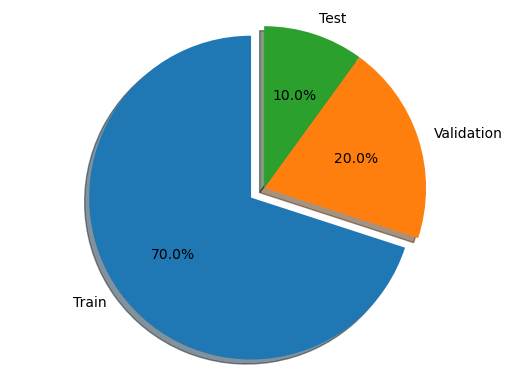

In [4]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# split the data into train, validation, and test sets
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = int(len(df) * 0.1)

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

# display the data sets representations using a pie chart just to see the distribution of the data
labels = 'Train', 'Validation', 'Test'
sizes = [len(train_df), len(val_df), len(test_df)]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Standardizing, tokenizing and indexing the data</b></p>
</div>

First, we need to parse our raw text data and vectorize it.

To keep things simple, we will first limit our vocabulary using the **max_tokens** parameter. We will also limit the length of each sample using the **sequence_length** parameter.

Each sample (text input) will be standardized, tokenized by word, and then indexed by token.

This will result in a matrix of vectors (input IDs) of shape "(batch_size, **sequence_length**)".

In [5]:
max_tokens = 25000
sequence_length = 30

# define a custom standardization function that convert to lowercase and strips all punctuations except "[" and "]" (so we can tell apart "start" from "[start]").
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
 
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

# tokenize the data using our custom standardization function
source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # add +1 token to our target sentences since they'll be shifted right by 1 during training
    standardize=custom_standardization,
)

# index all tokens in the source and target sentences
train_source_texts = train_df['source'].values
train_target_texts = train_df['target'].values
source_vectorization.adapt(train_source_texts)
target_vectorization.adapt(train_target_texts)

In [6]:
# display a random sample before and after vectorization just to test the vectorization
random_sample = random.randint(0, len(train_df))
print("Source texts (one random sample):", train_source_texts[random_sample])
print("Target texts (one random sample):", train_target_texts[random_sample])
print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))

# display the decoding of the vectorized text (from vector back to text) just to test the vectorization
source_decoded_text = ''
for i in range(len(source_vectorization(train_source_texts[random_sample]))):
    source_decoded_text += source_vectorization.get_vocabulary()[source_vectorization(train_source_texts[random_sample])[i]] + ' '
print("Source decoded texts (one random sample):", source_decoded_text)

target_decoded_text = ''
for i in range(len(target_vectorization(train_target_texts[random_sample]))):
    target_decoded_text += target_vectorization.get_vocabulary()[target_vectorization(train_target_texts[random_sample])[i]] + ' '
print("Target decoded texts (one random sample):", target_decoded_text)

Source texts (one random sample): Have you ever broken a bone?
Target texts (one random sample): [start] Vous êtes-vous jamais cassé un os ? [end]
Source vectors (one random sample): tf.Tensor(
[  18    3  199  766    6 3182    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(30,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[   2   12  221   68  976   16 3233    3    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(31,), dtype=int64)
Source decoded texts (one random sample): have you ever broken a bone                         
Target decoded texts (one random sample): [start] vous êtesvous jamais cassé un os [end]                        


In [7]:
# display the shape of our vectorized data
train_source_vectors = source_vectorization(train_source_texts)
train_target_vectors = target_vectorization(train_target_texts)
print("Source vectors (shape):", train_source_vectors.shape)
print("Target vectors (shape):", train_target_vectors.shape)

Source vectors (shape): (122934, 30)
Target vectors (shape): (122934, 31)


# Building the Transformer

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Positional Embedding</b></p>
</div>

In order for the Transformer to be aware of the word order in each sentence, we must add some positional information to the data.

First, each vector of tokens will be embedded in a low-dimensional vectors (the dimensionality of the embedding space is defined by the **embedding_size** parameter).

Secondly, position information will be created and embedded, before being added to the embedded tokens.

This will result in positional embeddings (position-aware word embeddings) stored in a matrix of shape "(batch_size, sequence_length, **embedding_size**)".

In [8]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim) # token embedding layer
        self.position_embeddings = tf.keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim) # position embedding layer
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs) # embed the tokens
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # create the positional information
        embedded_positions = self.position_embeddings(positions) # embed the positions 
        return embedded_tokens + embedded_positions # add the token and position embeddings to create the positional embeddings

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
        })
        return config

In [9]:
# display the shape of our embedded data just to test the class

embed_dim = 256

train_source_embedded = PositionalEmbedding(
    sequence_length=sequence_length,
    input_dim=max_tokens,
    output_dim=embed_dim,
    name="source_embedding",
) (train_source_vectors)

train_target_embedded = PositionalEmbedding(
    sequence_length=sequence_length,
    input_dim=max_tokens,
    output_dim=embed_dim,
    name="target_embedding",
) (train_source_vectors)

print("Source embedded vectors (shape):", train_source_embedded.shape)
print("Target embedded vectors (shape):", train_target_embedded.shape)

Source embedded vectors (shape): (122934, 30, 256)
Target embedded vectors (shape): (122934, 30, 256)


<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Attention mechanism</b></p>
</div>

A simple implementation of a Transformer's attention mechanism from scratch.

- Causal Masking
- Scaled Dot-Product Attention
- Multi-Head Attention

In practice, we could just use **tf.keras.layers.MultiHeadAttention** instead of building it from scratch. 😒

<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Causal Masking</b></p>
</div>

Let's define a Causal Masking function that will serve to mask the *future* tokens during training.

*[Credits to OpenAI](https://github.com/openai/gpt-2/blob/master/src/model.py) for that one.*

In [10]:
def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def attention_mask(nd, ns, *, dtype):
    """1's in the lower triangle, counting from the lower right corner.
    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)

def mask_attn_weights(w):
    # w has shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst.
    _, _, nd, ns = shape_list(w)
    b = attention_mask(nd, ns, dtype=w.dtype)
    b = tf.reshape(b, [1, 1, nd, ns])
    w = w*b - tf.cast(1e10, w.dtype)*(1-b)
    return w

In [11]:
# display the causal masking of a random tensor just to test the function
random_tensor = tf.random.uniform(shape=(1, 1, 5, 5), minval=0, maxval=1, dtype=tf.float32)
print("Masked attention weights:", mask_attn_weights(random_tensor))

Masked attention weights: tf.Tensor(
[[[[ 6.2196958e-01 -1.0000000e+10 -1.0000000e+10 -1.0000000e+10
    -1.0000000e+10]
   [ 3.5770154e-01  2.3619473e-01 -1.0000000e+10 -1.0000000e+10
    -1.0000000e+10]
   [ 2.1580112e-01  3.4929395e-02  1.6679084e-01 -1.0000000e+10
    -1.0000000e+10]
   [ 4.9473345e-01  2.1166432e-01  3.2739556e-01  5.5245554e-01
    -1.0000000e+10]
   [ 5.0063765e-01  1.5066671e-01  6.9962549e-01  8.6920905e-01
     8.9490736e-01]]]], shape=(1, 1, 5, 5), dtype=float32)


<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Scaled Dot-Product Attention</b></p>
</div>

The scaled dot product attention is calculated as follows :

***Attention(q, k, v) = softmax(qk^T / √(d_k))v***

Where **q**, **k** and **v** are the query, key, and value matrices and **d_k** is the dimensionality of the key matrix.

[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-19.png" width="100">](https://arxiv.org/abs/1706.03762)

In [12]:
def scaled_dot_product_attention(q, k, v, use_causal_mask=False):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) # Matmul of Q and K
    scaled_scores = scores / tf.math.sqrt(d_k) # Scale
    if use_causal_mask:
        scaled_scores = mask_attn_weights(scaled_scores) # Mask (opt.)
    weights = tf.nn.softmax(scaled_scores, axis=-1) # SoftMax
    outputs = tf.matmul(weights, v) # Matmul of SoftMax and V
    return outputs

In [13]:
# display the shape of our attention output just to test the function
input = train_source_embedded
input = tf.expand_dims(input, axis=1)
print("Scaled dot product attention (shape):", scaled_dot_product_attention(input, input, input, use_causal_mask=True).shape)

Scaled dot product attention (shape): (122934, 1, 30, 256)


<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Multi-Head Attention</b></p>
</div>

The multi-head attention is calculated as follows :

***MultiHead(q, k, v) = Concat(head_1, ..., head_h)W^O*** 

Where head_i is the i-th attention head, W^O is the output matrix, and **h** is the number of attention heads.

***head_i = Attention(qW_i^q, kW_i^k, vW_i^v)***

Where W_i^q, W_i^k, and W_i^v are the matrices for the i-th attention head.
    
[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-20.png" width="200">](https://arxiv.org/abs/1706.03762)

In [14]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, h, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.h = h
        if embed_dim % h != 0:
            raise ValueError(
                f"dimension of the embedding space = {embed_dim} should be divisible by number of heads = {h}"
            )
        self.q_linear = tf.keras.layers.Dense(embed_dim)
        self.k_linear = tf.keras.layers.Dense(embed_dim)
        self.v_linear = tf.keras.layers.Dense(embed_dim)
        self.concat_linear = tf.keras.layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, shape=(batch_size, -1, self.h, self.embed_dim // self.h))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def concat_heads(self, x, batch_size):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.embed_dim))

    def call(self, q, k, v, use_causal_mask=False):
        batch_size = tf.shape(k)[0]
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        attention = scaled_dot_product_attention(q, k, v, use_causal_mask)
        concat = self.concat_heads(attention, batch_size)
        concat = self.concat_linear(concat)
        return concat

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "h": self.h,
        })
        return config

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Encoder</b></p>
</div>

[<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter03_encoder-zoom.png" width="400">](https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb)

The role of the Encoder is to process the source sequence. Here, no Causal Masking is needed : information is allowed to flow in both directions.

The Encoder's a pretty generic module that ingests a sequence and learns to turn it into a more useful representation. It can also be used by itself (without the Decoder) for Natural Language Understanding (NLU) tasks like classification or named entity recognition (NER).

In the Encoder's Multi-Head Self-Attention layer ([Global self-attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_global_self_attention_layer)), the **Source Vectors Embeddings** are being passed to all three parameters : **Q**uery, **K**ey, and **V**alue.

In [15]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.global_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        
    def call(self, x):
        # Post layer normalization
        x = self.layer_norm_1(x + self.global_self_attention(q=x, k=x, v=x))
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Decoder</b></p>
</div>

[<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter03_decoder-zoom.png" width="500">](https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb)

The role of the Decoder is to look at the target sequence so far and predict the next token in the sequence.

Contrary to the Encoder, the Decoder is made of two Attention layers. The first Attention layer does a similar job as the Encoder's sole Attention layer, with the important distinction that here, Causal Masking is enabled because, to correctly train our Transformer to predict the next token, we need to mask the *future* tokens. Meanwhile, The second Attention layer is much more straight-forward and basically just acts as a bridge that connects the Encoder to the Decoder.

In the Decoder's first Attention layer, the Masked Multi-Head Self-Attention layer ([Causal self-attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_causal_self_attention_layer)), the **Target Vectors Embeddings** are being passed to all three parameters : **Q**uery, **K**ey, and **V**alue. Like mentionned above, Causal Masking is enabled in this layer.

In the Decoder's second Attention layer, the Encoder-Decoder Attention layer ([Cross attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_cross_attention_layer)), the **outputs of the Encoder** are being passed to the **K**ey and **V**alue parameters, with the **outputs of the Decoder's Masked Multi-Head Self-Attention layer** being passed to the **Q**uery parameter.


In [16]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.causal_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.cross_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.layer_norm_3 = tf.keras.layers.LayerNormalization()

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

    def call(self, x, context):
        # Post layer normalization
        x = self.layer_norm_1(x + self.causal_self_attention(q=x, k=x, v=x, use_causal_mask=True))
        x = self.layer_norm_2(x + self.cross_attention(q=x, k=context, v=context))
        x = self.layer_norm_3(x + self.feed_forward(x))
        return x

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Putting it all together</b></p>
</div>

[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-21.png" width="300">](https://arxiv.org/abs/1706.03762)

We  turn our data into a *tf.data pipeline* that returns a tuple (Inputs, Outputs) where Inputs is a dict with two keys : **encoder_inputs** (the source sequence) and **decoder_inputs** (the target sequence), and Outputs is a single key : **decoder_outputs** (the target sentence "shifted right").

During training, the fact that our Outputs are offset by one step ahead ("shifted right"), combined with the Causal Masking of the Decoder (Masked Multi-Head Attention layer), ensures that the
predictions for position *i* can depend only on the known outputs at positions less than *i* (no *future* token is seen).

During inference, we'll generate one target token at a time and then feed it back into the Decoder so that it can predict the next token. And so on.

In [17]:
batch_size = 64

def format_dataset(source, target):
    source_vectors = source_vectorization(source)
    target_vectors = target_vectorization(target)
    return ({
        "source": source_vectors, # encoder_inputs
        "target": target_vectors[:, :-1], # decoder_inputs (truncate by 1 to keep it at the same length as decoder_outputs, which is shifted right by 1).
    }, target_vectors[:, 1:]) # decoder_outputs

def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df["source"].values, df["target"].values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df)

In [18]:
# display the shape of the first batch of data in the dataset just to see what it looks like
for batch in train_ds.take(1):
    print("Encoder Inputs:", batch[0]["source"].shape)
    print("Decoder Inputs:", batch[0]["target"].shape)
    print("Decoder Outputs:", batch[1].shape)

Encoder Inputs: (64, 30)
Decoder Inputs: (64, 30)
Decoder Outputs: (64, 30)


[<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter03_transformer-encoder-decoder.png" width="600">](https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb)


In [19]:
embed_dim = 512 # dimension of the embedding space
dense_dim = 2048 # dimension of the feed forward network (a rule of thumb is to use 4 times the size of the embeddings)
num_heads = 8

# the transformer body
encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="source")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
decoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="target")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)

# the transformer head
x = tf.keras.layers.Dropout(0.5)(x)
decoder_outputs = tf.keras.layers.Dense(max_tokens, activation="softmax")(x)

transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Training the Transformer

In [20]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

EPOCHS = 50
checkpoint_filepath = '/tmp/checkpoint/'
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),
]
    
transformer.fit(train_ds, 
                epochs=EPOCHS, 
                callbacks=callbacks_list,
                validation_data=val_ds)

transformer.load_weights(checkpoint_filepath)

Epoch 1/50
1921/1921 [==============================] - 235s 117ms/step - loss: 1.0998 - accuracy: 0.8344 - val_loss: 0.6480 - val_accuracy: 0.8921 - lr: 0.0010
Epoch 2/50
1921/1921 [==============================] - 210s 109ms/step - loss: 0.6043 - accuracy: 0.8979 - val_loss: 0.5138 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 3/50
1921/1921 [==============================] - 210s 109ms/step - loss: 0.4871 - accuracy: 0.9120 - val_loss: 0.4610 - val_accuracy: 0.9160 - lr: 0.0010
Epoch 4/50
1921/1921 [==============================] - 210s 109ms/step - loss: 0.4219 - accuracy: 0.9203 - val_loss: 0.4390 - val_accuracy: 0.9199 - lr: 0.0010
Epoch 5/50
1921/1921 [==============================] - 209s 109ms/step - loss: 0.3768 - accuracy: 0.9264 - val_loss: 0.4298 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 6/50
1921/1921 [==============================] - 209s 109ms/step - loss: 0.3412 - accuracy: 0.9316 - val_loss: 0.4254 - val_accuracy: 0.9242 - lr: 0.0010
Epoch 7/50
1921/1921 [============

# Testing the Transformer

Let's translate a few random test sentences with our newly-trained Transformer.

In [21]:
target_vocab = target_vectorization.get_vocabulary()
target_index_lookup = dict(zip(range(len(target_vocab)), target_vocab))
max_decoded_sentence_length = 30

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

# let's translate 50 random sentences
for i in range(50):
    random_index = np.random.randint(0, len(test_df))
    input_sentence = test_df["source"].iloc[random_index]
    print(input_sentence)
    print(decode_sequence(input_sentence))
    print()

I want a martini.
[start] je veux un [UNK] [end]

I'd like to introduce you to my wife.
[start] jaimerais te présenter ma femme [end]

He is used to speaking in public.
[start] il a lhabitude de parler en public [end]

He complained about the noise.
[start] il sest plaint du bruit [end]

I'm real careful.
[start] je suis vraiment prudent [end]

My French is actually not so good.
[start] mon français nest en réalité pas si bon [end]

Don't think about the price.
[start] ny pense pas le prix [end]

How long do they wish to spend here?
[start] combien de temps ils veulent passer ici [end]

Do you see anything?
[start] estce que tu vois quelque chose [end]

The argument is rigorous and coherent but ultimately unconvincing.
[start] le argument est en train et [UNK] mais un [UNK] [end]

Let's put up the Christmas tree here.
[start] mettons un sapin de noël ici [end]

She has two brothers, who work in the computer industry.
[start] elle a deux frères qui travaille dans lindustrie informatique

# Credits and stuff

- https://arxiv.org/abs/1706.03762

- https://www.tensorflow.org/text/tutorials/transformer

- https://github.com/openai/gpt-2/blob/master/src/model.py

- https://github.com/karpathy/minGPT/blob/master/mingpt/model.py

- https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11

    - https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb

    - https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb

- https://www.oreilly.com/library/view/natural-language-processing/9781098136789/ch03.html

    - https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb